In [2]:
import helics as h
from opendssdirect import dss
import pandas as pd
import time
import threading
import os
import matplotlib.pyplot as plt

In [3]:
simulation_time = 300
time_step = 1.0

# Set the working directory
base_dir = r"C:/Users/nicol/Helics_experimental"
os.chdir(base_dir)

In [4]:
def csv_to_dss_name(csv_name):
    """
    Convert a CSV bus name (e.g., 'S701a' or '701a' or even '728') to the DSS load name.
    Ensures the name has a leading 'S' and is in lower-case.
    """
    if not csv_name.startswith('S') and not csv_name.startswith('s'):
        csv_name = 'S' + csv_name
    return csv_name.lower()

def dss_to_csv_name(dss_name):
    """
    Convert a DSS load name (e.g., 's701a') back to the CSV naming convention (e.g., 'S701a').
    """
    return dss_name.capitalize()

In [5]:
# =============================================================================
# HELICS Broker Setup
# =============================================================================
def start_broker():
    global broker
    broker = h.helicsCreateBroker("zmq", "", "--federates=2")

broker_thread = threading.Thread(target=start_broker, daemon=True)
broker_thread.start()
time.sleep(1)  # Allow the broker to initialize

In [6]:
# =============================================================================
# OpenDSS Federate
# =============================================================================
def run_opendss_federate():
    fedinfo = h.helicsCreateFederateInfo()
    h.helicsFederateInfoSetCoreName(fedinfo, "OpenDSS_Federate")
    h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
    h.helicsFederateInfoSetTimeProperty(fedinfo, h.HELICS_PROPERTY_TIME_DELTA, time_step)

    fed = h.helicsCreateValueFederate("OpenDSS_Federate", fedinfo)

    pub = h.helicsFederateRegisterPublication(fed, "voltage_out", h.HELICS_DATA_TYPE_STRING, "")
    sub = h.helicsFederateRegisterSubscription(fed, "Voltage_Consumer_Federate/net_demand", "")

    h.helicsFederateEnterExecutingMode(fed)

    # Load the IEEE37 DSS file and print available load and bus names for diagnostics.
    dss.Command(f"Redirect {base_dir}/data/ieee37.dss")
    print("Loads in DSS after redirect:", dss.Loads.AllNames())
    print("Buses in DSS:", dss.Circuit.AllBusNames())

    current_time = 0
    while current_time < simulation_time:
        next_time = current_time + time_step
        granted_time = h.helicsFederateRequestTime(fed, next_time)
        print(f"[OpenDSS] Granted time: {granted_time}")

        # Wait for net_demand value to be published
        timeout_counter = 0
        while not h.helicsInputIsUpdated(sub):
            time.sleep(0.01)
            timeout_counter += 1
            if timeout_counter > 100:
                print(f"[WARN] No net_demand received at t={granted_time}")
                break

        net_demand_str = h.helicsInputGetString(sub)
        try:
            if net_demand_str.strip().startswith('{'):
                net_demand = eval(net_demand_str)
                if isinstance(net_demand, dict):
                    # Use lower-case key since consumer publishes lower-case keys.
                    if 's701a' in net_demand:
                        print(f"[OpenDSS] Received net demand at time {granted_time}: {net_demand['s701a']}")
                    else:
                        print(f"[OpenDSS] Net demand does not contain key 's701a'. Keys received: {list(net_demand.keys())}")
                    for bus, kw in net_demand.items():
                        # Convert CSV bus name to DSS naming convention.
                        dss_bus = csv_to_dss_name(bus)
                        # Check if the load exists in the circuit
                        if dss_bus in dss.Loads.AllNames():
                            dss.Loads.Name(dss_bus)
                            dss.Loads.kW(kw)
                        else:
                            print(f"[INFO] Load {dss_bus} not found in Active Circuit. Skipping this node.")
            else:
                print(f"[WARN] Invalid net_demand string: '{net_demand_str}'")
        except Exception as e:
            print(f"[ERROR] Failed to parse net_demand: {e}")

        # Solve the circuit
        dss.Solution.Solve()

        # Retrieve per-phase voltage values
        voltage_dict = {}
        bus_names = dss.Circuit.AllBusNames()
        for bus in bus_names:
            dss.Circuit.SetActiveBus(bus)
            # Get voltage data as a list: [V_phase1, angle1, V_phase2, angle2, ...]
            voltage_data = dss.Bus.puVmagAngle()
            num_phases = dss.Bus.NumNodes()
            # Assume DSS bus names do not include a phase suffix; add one for each phase.
            for i in range(num_phases):
                phase_label = chr(ord('a') + i)
                key = bus.lower() + phase_label
                voltage_dict[key] = voltage_data[2 * i]  # Extract the magnitude

        # Publish the voltage dictionary as a string
        h.helicsPublicationPublishString(pub, str(voltage_dict))

        current_time = granted_time

    h.helicsFederateFinalize(fed)
    print("[OpenDSS Federate] Finalized.")

In [7]:
# =============================================================================
# Data Loading and Helper Function
# =============================================================================
solar_data = pd.read_csv(r"C:\\Users\\nicol\\Helics_experimental\\data\\solar_data.csv")
solar_data.columns = solar_data.columns.str.replace('_pv$', '', regex=True)
solar_data['time'] = solar_data.index

load_data = pd.read_csv(r"C:\\Users\\nicol\\Helics_experimental\\data\\load_data.csv")
load_data['time'] = load_data.index
load_data.sort_values('time', inplace=True)

# Assume node names are the columns in solar_data except for 'time'
node_names = [col for col in solar_data.columns if col != 'time']

def get_values_at_time(t, df):
    if t in df['time'].values:
        row = df[df['time'] == t].iloc[0]
    else:
        row = df.iloc[-1]
    return row.drop('time').to_dict()

In [8]:
# =============================================================================
# Voltage Consumer Federate
# =============================================================================
def run_voltage_consumer_federate():
    fedinfo = h.helicsCreateFederateInfo()
    h.helicsFederateInfoSetCoreName(fedinfo, "Voltage_Consumer_Federate")
    h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq")
    h.helicsFederateInfoSetTimeProperty(fedinfo, h.HELICS_PROPERTY_TIME_DELTA, time_step)

    fed = h.helicsCreateValueFederate("Voltage_Consumer_Federate", fedinfo)

    pub = h.helicsFederateRegisterPublication(fed, "net_demand", h.HELICS_DATA_TYPE_STRING, "")
    sub = h.helicsFederateRegisterSubscription(fed, "OpenDSS_Federate/voltage_out", "")

    h.helicsFederateEnterExecutingMode(fed)
    time.sleep(1)  # Ensure publisher is ready

    current_time = 0
    end_time = simulation_time
    voltage_timeseries = []

    while current_time < end_time:
        solar_values = get_values_at_time(current_time, solar_data)
        load_values = get_values_at_time(current_time, load_data)

        # Compute net demand for each node (load minus solar generation)
        # Convert keys to lower-case so they match in OpenDSS.
        net_demand = {node.lower(): load_values.get(node, 0) - solar_values.get(node, 0) for node in node_names}
        print(f"[Consumer] Time: {current_time} | Net Demand: {net_demand.get('s701a', 'N/A')}")

        h.helicsPublicationPublishString(pub, str(net_demand))

        next_time = current_time + time_step
        granted_time = h.helicsFederateRequestTime(fed, next_time)
        print(f"[Consumer] Granted time: {granted_time}")
        current_time = granted_time

        # Wait for voltage update
        voltage_timeout = 0
        while not h.helicsInputIsUpdated(sub) and voltage_timeout < 100:
            time.sleep(0.01)
            voltage_timeout += 1

        voltage_str = h.helicsInputGetString(sub)
        if voltage_str.strip().startswith('{'):
            try:
                voltage_data = eval(voltage_str)
                if isinstance(voltage_data, dict):
                    # Convert DSS bus names back to CSV naming convention.
                    voltage_data_csv = {dss_to_csv_name(key): value for key, value in voltage_data.items()}
                    voltage_data_csv['time'] = current_time
                    voltage_timeseries.append(voltage_data_csv.copy())
                    print(f"[Consumer] Time: {current_time} | Voltages: {voltage_data_csv.get('701a', 'N/A')}")
                else:
                    print(f"[WARN] Received non-dict voltage data: {voltage_data}")
            except Exception as e:
                print(f"[ERROR] Failed to evaluate voltage data: {e}")
        else:
            print(f"[WARN] Empty or malformed voltage string: '{voltage_str}'")

    h.helicsFederateFinalize(fed)
    print("[Voltage Consumer Federate] Finalized.")

    try:
        voltage_df = pd.DataFrame(voltage_timeseries)
        voltage_df.to_csv("voltage_timeseries.csv", index=False)
        print("[Voltage Data] Saved to 'voltage_timeseries.csv'")
    except Exception as e:
        print(f"[ERROR] Could not save voltage data: {e}")

In [9]:
# =============================================================================
# Run the Simulation
# =============================================================================
# Start the consumer thread first so net_demand is published before OpenDSS begins.
consumer_thread = threading.Thread(target=run_voltage_consumer_federate)
opendss_thread = threading.Thread(target=run_opendss_federate)

consumer_thread.start()
time.sleep(1.0)  # Allow the consumer federate to start and publish initial net_demand values.
opendss_thread.start()

consumer_thread.join()
opendss_thread.join()

if 'broker' in globals() and h.helicsBrokerIsConnected(broker):
    h.helicsBrokerDisconnect(broker)
    h.helicsBrokerFree(broker)

print("Simulation complete. Broker closed.")


Loads in DSS after redirect: ['s701a', 's701b', 's701c', 's712c', 's713c', 's714a', 's714b', 's718a', 's720c', 's722b', 's722c', 's724b', 's725b', 's727c', 's728', 's729a', 's730c', 's731b', 's732c', 's733a', 's734c', 's735c', 's736b', 's737a', 's738a', 's740c', 's741c', 's742a', 's742b', 's744a']
Buses in DSS: ['sourcebus', '799', '701', '702', '705', '713', '703', '727', '730', '704', '714', '720', '742', '712', '706', '725', '707', '724', '722', '708', '733', '732', '709', '731', '710', '735', '736', '711', '741', '740', '718', '744', '734', '737', '738', '728', '729', '799r']
[Consumer] Time: 0 | Net Demand: 48.65106259999999
[Consumer] Granted time: 1.0
[OpenDSS] Granted time: 1.0
[OpenDSS] Received net demand at time 1.0: 48.65106259999999
[INFO] Load s728a not found in Active Circuit. Skipping this node.
[WARN] Empty or malformed voltage string: '-9999999999999999464902769475481793196872414789632.000000'
[Consumer] Time: 1.0 | Net Demand: 48.90207480000001
[Consumer] Granted tim

c:\Users\nicol\anaconda3\envs\magic_exp_PG\lib\site-packages\helics\capi.py:4444: UserWarning: This function is deprecated. Use `helicsFederateDisconnect` instead.
  warnings.warn("This function is deprecated. Use `helicsFederateDisconnect` instead.")


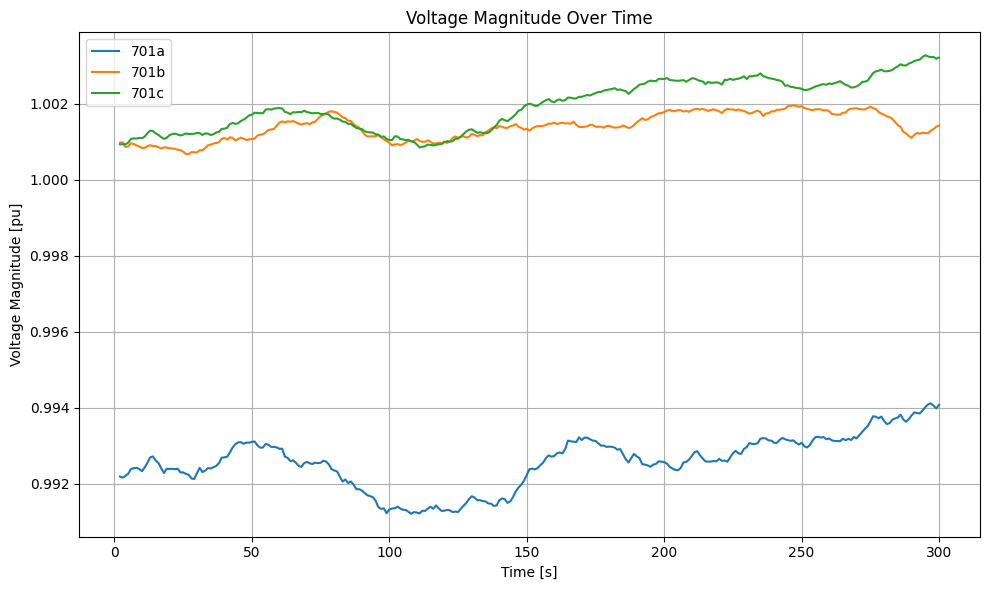

In [10]:
# Load the voltage timeseries data
df = pd.read_csv("voltage_timeseries.csv")

# --- Choose the nodes you want to plot ---
nodes_to_plot = ["701a", "701b", "701c"]  # Change these to your desired nodes

# --- Check if the columns exist ---
missing = [n for n in nodes_to_plot if n not in df.columns]
if missing:
    print(f"[ERROR] The following nodes are missing in the CSV: {missing}")
    print("Available nodes:", list(df.columns))
    exit()

# --- Plotting ---
plt.figure(figsize=(10, 6))
for node in nodes_to_plot:
    plt.plot(df['time'], df[node], label=node)

plt.xlabel("Time [s]")
plt.ylabel("Voltage Magnitude [pu]")
plt.title("Voltage Magnitude Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()